# CSC-786 Activity 4: Food Waste Nutrition Analysis
  **Author:** Manuel Marin

  ## 📋 Instructions

  ### Before Running This Notebook:

  1. **Get your FREE API key** from the USDA FoodData Central:
     - Visit: https://fdc.nal.usda.gov/api-key-signup
     - Fill out the form and you'll receive your API key via email

  2. **Set your API key securely**:
  
      - Click the **🔑 key icon** on the left sidebar (*Secrets* tab).  
      - Click **“+ Add new secret”**, name it `FOOD_DATA_API_KEY`, and paste your API key.  
      - The notebook will automatically retrieve it using:
      ```python
      from google.colab import userdata
      API_KEY = userdata.get('FOOD_DATA_API_KEY')
      ```
      Your key stays private and never appears in notebook cells or outputs.

  3. **Run all cells** to collect food nutrition data and generate visualizations

> **When using Google Colab**
> Download this notebook and open it in Google Colab for best results.

> **Note on Comparing Outputs**  
> The best way to review and compare results is to open this notebook directly from the [repository](https://github.com/ManuelMarin-02/csc786-a4-manuel-marin).  
> Click on the `.ipynb` file to view it in GitHub’s notebook preview.  
> Then, compare the output of each cell in your own run with the outputs shown there — this will help verify that your environment reproduces the same results and figures.


## Setup Environment

In [72]:
# Install exact deps for a clean runtime
!pip install -q pandas requests matplotlib python-dotenv

In [73]:
!pip install python-dotenv --quiet
import os, pandas as pd, requests, hashlib, json, sys, time, matplotlib
from datetime import datetime, timezone
from pathlib import Path
import matplotlib.pyplot as plt


ROOT = Path("/content")
DATA = ROOT / "data"
DATA.mkdir(exist_ok=True)
print("Environment ready. Files will be stored in:", DATA)


Environment ready. Files will be stored in: /content/data


# API Key Setup
## Get your API Key from https://fdc.nal.usda.gov/api-key-signup

In [74]:
from google.colab import userdata  # available only in Colab
API_KEY = userdata.get('FOOD_DATA_API_KEY')

### USDA FoodData Central API - Get list of foods with comprehensive data

In [75]:

url = "https://api.nal.usda.gov/fdc/v1/foods/list"
params = {
    "api_key": API_KEY,
    "pageSize": 50,      # Get more foods for better plotting
    "pageNumber": 1
}

r = requests.get(url, params=params, timeout=10)
r.raise_for_status()
data = r.json()

# Extract comprehensive food data for plotting
foods_data = []
for food in data:
    food_info = {
        "fdcId": food.get("fdcId"),
        "description": food.get("description"),
        "dataType": food.get("dataType"),  # Good for categorical plotting
        "publicationDate": food.get("publicationDate", "N/A"),
        "brandOwner": food.get("brandOwner", "N/A"),
    }

    # Extract key nutrients for plotting
    nutrients = food.get("foodNutrients", [])
    nutrient_dict = {}

    for nutrient in nutrients:
        nutrient_name = nutrient.get("nutrientName", "")
        nutrient_value = nutrient.get("value", 0)
        nutrient_unit = nutrient.get("unitName", "")

        # Store common nutrients useful for plotting
        if "Energy" in nutrient_name or "Protein" in nutrient_name or \
            "Carbohydrate" in nutrient_name or "Fat" in nutrient_name or \
            "Fiber" in nutrient_name or "Sugar" in nutrient_name:
            nutrient_dict[nutrient_name] = {
                "value": nutrient_value,
                "unit": nutrient_unit
            }

    # Add nutrients to food_info
    food_info["nutrients"] = nutrient_dict
    food_info["nutrient_count"] = len(nutrients)  # Track how many nutrients available

    foods_data.append(food_info)

foods_data


[{'fdcId': 2715733,
  'description': 'A comprehensive characterization of phenolics, amino acids and other minor bioactives of selected honeys and identification of botanical origin markers',
  'dataType': 'Experimental',
  'publicationDate': '2024-10-31',
  'brandOwner': 'N/A',
  'nutrients': {},
  'nutrient_count': 0},
 {'fdcId': 2715727,
  'description': 'A Fast and Simple Solid Phase Extraction-Based Method for Glucosinolate Determination: An Alternative to the ISO-9167 Method',
  'dataType': 'Experimental',
  'publicationDate': '2024-10-31',
  'brandOwner': 'N/A',
  'nutrients': {},
  'nutrient_count': 0},
 {'fdcId': 2353623,
  'description': 'A Low-Starch and High-Fiber Diet Intervention Impacts the Microbial Community of Raw Bovine Milk',
  'dataType': 'Experimental',
  'publicationDate': '2022-10-28',
  'brandOwner': 'N/A',
  'nutrients': {},
  'nutrient_count': 0},
 {'fdcId': 2706337,
  'description': 'Abalone',
  'dataType': 'Survey (FNDDS)',
  'publicationDate': '2024-10-31'

In [76]:
df = pd.DataFrame(foods_data)

print(f"Retrieved {len(df)} foods")
print(f"\nData types available: {df['dataType'].unique()}")
print(f"\nColumns available: {df.columns.tolist()}")
df.head()


Retrieved 50 foods

Data types available: ['Experimental' 'Survey (FNDDS)' 'SR Legacy']

Columns available: ['fdcId', 'description', 'dataType', 'publicationDate', 'brandOwner', 'nutrients', 'nutrient_count']


,fdcId,description,dataType,publicationDate,brandOwner,nutrients,nutrient_count
0,2715733,"A comprehensive characterization of phenolics,...",Experimental,2024-10-31,N/A,{},0
1,2715727,A Fast and Simple Solid Phase Extraction-Based...,Experimental,2024-10-31,N/A,{},0
2,2353623,A Low-Starch and High-Fiber Diet Intervention ...,Experimental,2022-10-28,N/A,{},0
3,2706337,Abalone,Survey (FNDDS),2024-10-31,N/A,{},65
4,167782,"Abiyuch, raw",SR Legacy,2019-04-01,N/A,{},32


# Search for commonly wasted restaurant foods

In [77]:
commonly_wasted = ["french fries", "bread", "pizza", "salad", "chicken wings"]
SEARCH_ENDPOINT = "https://api.nal.usda.gov/fdc/v1/foods/search"

all_foods = []

for food_name in commonly_wasted:
    params = {
        "api_key": API_KEY,
        "query": food_name,
        "pageSize": 1
    }

    try:
        r = requests.get(SEARCH_ENDPOINT, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()

        if data.get("foods"):
            food = data["foods"][0]

            nutrients_dict = {}
            for nutrient in food.get("foodNutrients", []):
                name = nutrient.get("nutrientName", "")
                value = nutrient.get("value", 0)

                if "Energy" in name:
                    nutrients_dict["Calories"] = value
                elif name == "Protein":
                    nutrients_dict["Protein (g)"] = value
                elif name == "Total lipid (fat)":
                    nutrients_dict["Fat (g)"] = value
                elif name == "Carbohydrate, by difference":
                    nutrients_dict["Carbs (g)"] = value

            all_foods.append({
                "food_name": food.get("description"),
                "search_term": food_name,
                "fdcId": food.get("fdcId"),
                "dataType": food.get("dataType"),
                **nutrients_dict
            })

            print(f"✓ Found: {food.get('description')}")

    except Exception as e:
        print(f"✗ Error fetching {food_name}: {e}")


✓ Found: FRENCH FRIES
✓ Found: BREAD
✓ Found: PIZZA
✓ Found: SALAD
✓ Found: CHICKEN WINGS


## Create DataFrame

In [78]:
df = pd.DataFrame(all_foods)

if "Calories" not in df.columns:
    print("\n⚠ Calories not found. Calculating from macronutrients...")
    df["Calories"] = (
        df.get("Protein (g)", 0) * 4 +
        df.get("Carbs (g)", 0) * 4 +
        df.get("Fat (g)", 0) * 9
    )
    calories_calculated = True
    print("✓ Calories calculated")
else:
    calories_calculated = False

print(f"\nDataFrame created with {len(df)} foods")
print(df)


DataFrame created with 5 foods
       food_name    search_term    fdcId dataType  Protein (g)  Fat (g)  \
0   FRENCH FRIES   french fries  2093015  Branded         2.38     8.33   
1          BREAD          bread  2058078  Branded         3.57     0.00   
2          PIZZA          pizza  2036440  Branded         6.80     8.84   
3          SALAD          salad  2637940  Branded         2.63     4.61   
4  CHICKEN WINGS  chicken wings  1906811  Branded        18.60    18.60   

   Carbs (g)  Calories  
0       22.6       179  
1       32.1       146  
2       32.0       238  
3       27.0       151  
4        0.0       283  



## Generate timestamp ONCE for all files


In [79]:
timestamp = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H%M%SZ")

## Save CSV

In [80]:
out_csv = DATA / f"food_nutrition_data_{timestamp}.csv"
df.to_csv(out_csv, index=False)
print(f"\n✓ Data saved to CSV: {out_csv.name}")

# Calculate hash
file_hash = hashlib.sha256(out_csv.read_bytes()).hexdigest()
print(f"✓ File hash: {file_hash[:16]}...")


✓ Data saved to CSV: food_nutrition_data_2025-10-26T185539Z.csv
✓ File hash: b31e24346841ad45...


## Create Calories Chart


✓ Plot 1 saved: food_waste_calories_2025-10-26T185539Z.png


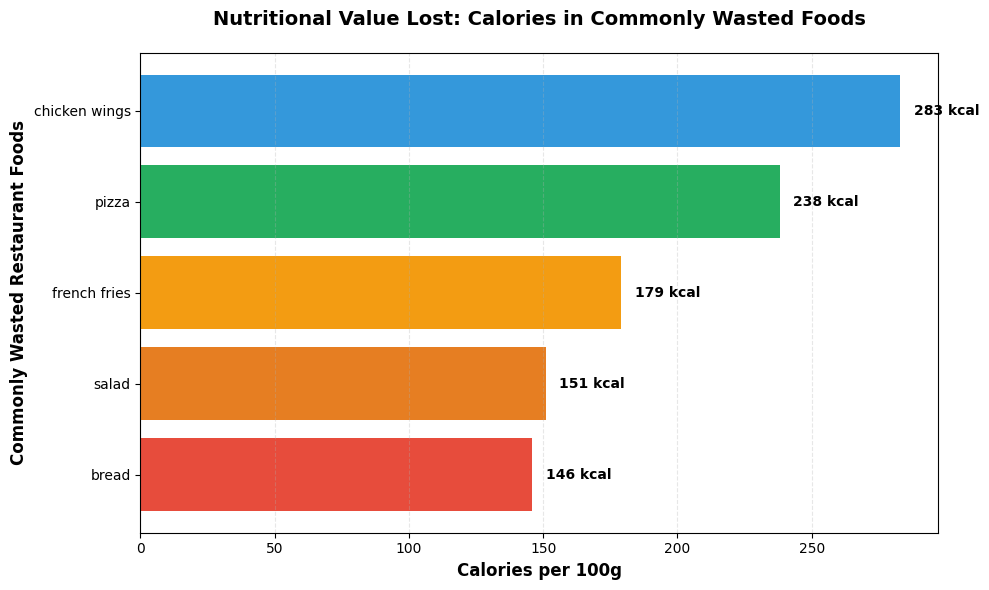

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
df_sorted = df.sort_values('Calories', ascending=True)
colors = ['#e74c3c', '#e67e22', '#f39c12', '#27ae60', '#3498db']
bars = ax.barh(df_sorted['search_term'], df_sorted['Calories'], color=colors)

ax.set_xlabel('Calories per 100g', fontsize=12, weight='bold')
ax.set_ylabel('Commonly Wasted Restaurant Foods', fontsize=12, weight='bold')
ax.set_title('Nutritional Value Lost: Calories in Commonly Wasted Foods',
              fontsize=14, weight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bar, val in zip(bars, df_sorted['Calories']):
    ax.text(val + 5, bar.get_y() + bar.get_height()/2,
            f'{val:.0f} kcal', va='center', fontsize=10, weight='bold')

plt.tight_layout()
plot_file1 = DATA / f"food_waste_calories_{timestamp}.png"
plt.savefig(plot_file1, dpi=300, bbox_inches='tight')
print(f"\n✓ Plot 1 saved: {plot_file1.name}")
plt.show()


## Create Nutrients Chart

✓ Plot 2 saved: food_waste_nutrients_2025-10-26T185539Z.png


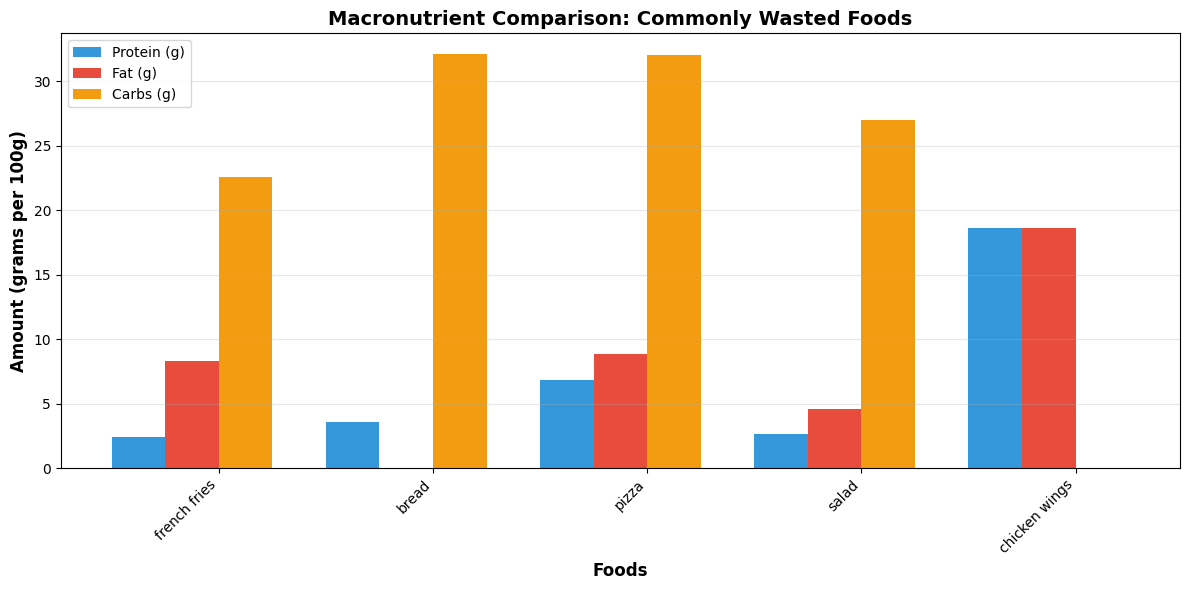

In [82]:
nutrient_cols = [col for col in df.columns if col not in ['food_name', 'search_term', 'Calories', 'fdcId', 'dataType']]

plot_file2 = None
if len(nutrient_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))

    x = range(len(df))
    width = 0.25
    colors_nutrients = ['#3498db', '#e74c3c', '#f39c12']

    for i, col in enumerate(nutrient_cols):
        if col in df.columns:
            offset = width * (i - len(nutrient_cols)/2)
            ax.bar([p + offset for p in x], df[col], width,
                    label=col, color=colors_nutrients[i % len(colors_nutrients)])

    ax.set_xlabel('Foods', fontsize=12, weight='bold')
    ax.set_ylabel('Amount (grams per 100g)', fontsize=12, weight='bold')
    ax.set_title('Macronutrient Comparison: Commonly Wasted Foods',
                  fontsize=14, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['search_term'], rotation=45, ha='right')
    ax.legend(loc='upper left')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plot_file2 = DATA / f"food_waste_nutrients_{timestamp}.png"
    plt.savefig(plot_file2, dpi=300, bbox_inches='tight')
    print(f"✓ Plot 2 saved: {plot_file2.name}")
    plt.show()


## LOG PROVENANCE TO DATA_README.md

In [83]:
meta = {
    "timestamp_utc": timestamp,
    "endpoint": SEARCH_ENDPOINT,
    "search_terms": commonly_wasted,
    "foods_collected": len(df),
    "params": {
        "pageSize": 1,
        "api_key": "REDACTED"
    },
    "output_csv": out_csv.name,
    "output_plot1": plot_file1.name,
    "output_plot2": plot_file2.name if plot_file2 else None,
    "sha256_csv": file_hash,
    "calories_calculated": calories_calculated,
    "python": sys.version.split()[0],
    "pandas": pd.__version__,
    "requests": requests.__version__,
    "matplotlib": matplotlib.__version__,
}

with open(ROOT / "DATA_README.md", "a") as f:
    f.write(f"\n\n```json\n{json.dumps(meta, indent=2)}\n```")

print(f"\n✓ Metadata logged to DATA_README.md")


✓ Metadata logged to DATA_README.md


# Display Summary

In [84]:

print("\n" + "="*60)
print("📊 DATA COLLECTION SUMMARY")
print("="*60)
print(f"Timestamp:       {timestamp}")
print(f"Foods collected: {len(df)}")
print(f"CSV file:        {out_csv.name}")
print(f"Chart 1:         {plot_file1.name}")
if plot_file2:
    print(f"Chart 2:         {plot_file2.name}")
print(f"SHA-256 hash:    {file_hash[:16]}...")
print("="*60)

# Display last entries in DATA_README.md
print("\n📄 Latest DATA_README.md entries:")
!tail -n 25 {ROOT / "DATA_README.md"}


📊 DATA COLLECTION SUMMARY
Timestamp:       2025-10-26T185539Z
Foods collected: 5
CSV file:        food_nutrition_data_2025-10-26T185539Z.csv
Chart 1:         food_waste_calories_2025-10-26T185539Z.png
Chart 2:         food_waste_nutrients_2025-10-26T185539Z.png
SHA-256 hash:    b31e24346841ad45...

📄 Latest DATA_README.md entries:
  "timestamp_utc": "2025-10-26T185539Z",
  "endpoint": "https://api.nal.usda.gov/fdc/v1/foods/search",
  "search_terms": [
    "french fries",
    "bread",
    "pizza",
    "salad",
    "chicken wings"
  ],
  "foods_collected": 5,
  "params": {
    "pageSize": 1,
    "api_key": "REDACTED"
  },
  "output_csv": "food_nutrition_data_2025-10-26T185539Z.csv",
  "output_plot1": "food_waste_calories_2025-10-26T185539Z.png",
  "output_plot2": "food_waste_nutrients_2025-10-26T185539Z.png",
  "sha256_csv": "b31e24346841ad4524b100d0feb2aff0ec17d770769897b344317e3ad4b53753",
  "calories_calculated": false,
  "python": "3.12.12",
  "pandas": "2.2.2",
  "requests": "2.32.